In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [182]:
df_ = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')

### EDA

In [116]:
df_.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


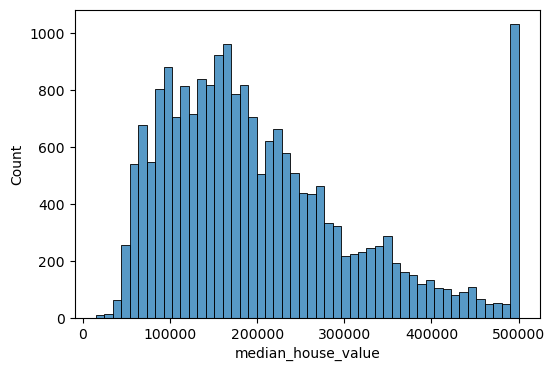

In [117]:
plt.figure(figsize=(6, 4))
sns.histplot(df_['median_house_value'], bins=50);
# it is right skewed

### Preparing the Dataset

In [179]:
# select ocean_proximity is <1H OCEAN or INLAND
df = df_[df_['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])].drop(columns=['ocean_proximity']).copy()

In [150]:
df.shape

(15687, 9)

### Q1- There's one feature with missing values. What is it?

In [33]:
df.isnull().sum()[df.isnull().sum() > 0] / df.shape[0] * 100
# 157 missing values in total_bedrooms
# % 1 of total data

total_bedrooms    1.000829
dtype: float64

### Q2- What's the median (50% percentile) for variable 'population'?

In [34]:
df.population.median()

1195.0

### Prepare and split the dataset

In [180]:
# Shuffle the dataset (the filtered one you created above), use seed 42.
# Split your data in train/val/test sets, with 60%/20%/20% distribution.
# Apply the log transformation to the median_house_value variable using the np.log1p() function.

np.random.seed(42)

df['median_house_value'] = np.log1p(df['median_house_value'])

n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

X_train = df_train.drop(columns=['median_house_value'])
y_train = df_train['median_house_value']

X_val = df_val.drop(columns=['median_house_value'])
y_val = df_val['median_house_value']

X_test = df_test.drop(columns=['median_house_value'])
y_test = df_test['median_house_value']

X_train['total_bedrooms'].fillna(0, inplace=True)
X_val['total_bedrooms'].fillna(0, inplace=True)

In [183]:
def prep_dataset(df, seed_num=42):
    np.random.seed(seed_num)
    df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])].drop(columns=['ocean_proximity']).copy()
    df['median_house_value'] = np.log1p(df['median_house_value'])

    n = len(df)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    X_train = df_train.drop(columns=['median_house_value'])
    y_train = df_train['median_house_value']

    X_val = df_val.drop(columns=['median_house_value'])
    y_val = df_val['median_house_value']

    X_test = df_test.drop(columns=['median_house_value'])
    y_test = df_test['median_house_value']
    
    return X_train, y_train, X_val, y_val, X_test, y_test

### Q3

In [152]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [153]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [184]:
# fill missing values with 0 in total_bedrooms
X_train, y_train, X_val, y_val, X_test, y_test = prep_dataset(df_)
X_train['total_bedrooms']  = X_train['total_bedrooms'].fillna(0)
X_val['total_bedrooms']  = X_val['total_bedrooms'].fillna(0)

w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_val.dot(w)
round(rmse(y_val, y_pred), 2)

0.34

In [185]:
# fill missing values with mean in total_bedrooms
X_train, y_train, X_val, y_val, X_test, y_test = prep_dataset(df_)
X_train['total_bedrooms']  = X_train['total_bedrooms'].fillna(X_train['total_bedrooms'].mean())
X_val['total_bedrooms']  = X_val['total_bedrooms'].fillna(X_train['total_bedrooms'].mean())

w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_val.dot(w)
round(rmse(y_val, y_pred), 2)

0.34

### Q4

In [188]:
def train_linear_regression_with_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [189]:
X_train, y_train, X_val, y_val, X_test, y_test = prep_dataset(df_)
X_train['total_bedrooms']  = X_train['total_bedrooms'].fillna(0)
X_val['total_bedrooms']  = X_val['total_bedrooms'].fillna(0)

In [190]:
r_list = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

for r in r_list:
    w_0, w = train_linear_regression_with_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print(r, round(rmse(y_val, y_pred), 2))

0 0.34
1e-06 0.34
0.0001 0.34
0.001 0.34
0.01 0.34
0.1 0.34
1 0.34
5 0.35
10 0.35


### Q5

In [192]:
seed_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

rmse_list = []

for seed in seed_list:
    X_train, y_train, X_val, y_val, X_test, y_test = prep_dataset(df_, seed_num=seed)
    X_train['total_bedrooms']  = X_train['total_bedrooms'].fillna(0)
    X_val['total_bedrooms']  = X_val['total_bedrooms'].fillna(0)
    w_0, w = train_linear_regression(X_train, y_train)
    y_pred = w_0 + X_val.dot(w)
    rmse_list.append(rmse(y_val, y_pred))

In [193]:
round(np.std(rmse_list), 3)

0.005

### Q6

In [194]:
X_train, y_train, X_val, y_val, X_test, y_test = prep_dataset(df_, seed_num=9)
X_train['total_bedrooms']  = X_train['total_bedrooms'].fillna(0)
X_val['total_bedrooms']  = X_val['total_bedrooms'].fillna(0)
X_test['total_bedrooms']  = X_test['total_bedrooms'].fillna(0)

X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

w_0, w = train_linear_regression_with_reg(X_full_train, y_full_train, r=0.001)
y_pred = w_0 + X_test.dot(w)
print(round(rmse(y_test, y_pred), 2))

0.33
